# Mount drive and unzip the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/UNet-PyTorch.zip" -d "/content/small"


# Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor


# Creating class Segmentation dataset to handle data

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_names = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.image_names[idx])

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, self.img_size) / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size) / 255.0

        # img = ToTensor()(img)
        # mask = ToTensor()(mask)
        img = ToTensor()(img).float()
        mask = ToTensor()(mask).float()

        return img, mask


# Defining U-net architecture

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        d1, p1 = self.down1(x)
        d2, p2 = self.down2(p1)
        d3, p3 = self.down3(p2)
        d4, p4 = self.down4(p3)

        b = self.bottleneck(p4)

        u1 = self.up1(b, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)

        return self.out(u4)


# Training process begins

In [ ]:
train_dataset = SegmentationDataset('/content/small/small/data/train', '/content/small/small/data/train_masks')
val_dataset = SegmentationDataset('/content/small/small/data/manual_test', '/content/small/small/data/manual_test_masks')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader)}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss / len(val_loader)}")


In [ ]:
# model.eval()
# test_image, test_mask = train_dataset[5]
# test_image = test_image.unsqueeze(0).to(device)
# predicted_mask = torch.sigmoid(model(test_image))
# predicted_mask = (predicted_mask > 0.08).float()

# predicted_mask = predicted_mask.squeeze(0).cpu().numpy()


In [ ]:
# # Get the first validation image and mask
# val_image, val_mask = train_dataset[5]


# val_image_np = val_image.permute(1, 2, 0).cpu().numpy()

# # Plot the image
# import matplotlib.pyplot as plt

# plt.imshow(val_image_np)
# plt.title("Validation Image")
# plt.axis('off')
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Ensure the predicted mask is in the correct shape and scale
# plt.imshow(predicted_mask[0], cmap='gray')
# plt.title("Predicted Mask")
# plt.axis('off')
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt


# train_mask_image = train_masks[5]


# # train_mask_image_np = train_mask_image.squeeze(0).cpu().numpy()

# # Plot the mask
# plt.imshow(train_mask_image, cmap='gray')
# plt.title("First Train Mask Image")
# plt.axis('off')
# plt.show()


# Prediction on unseen images

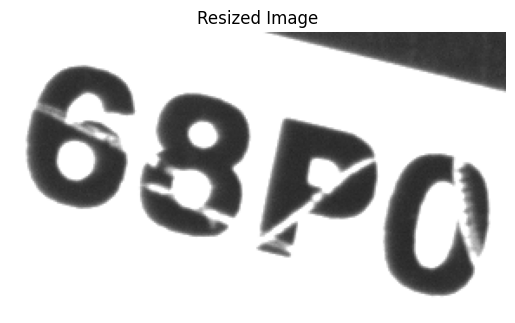

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open and resize the image
img = Image.open("/content/small/small/data/manual_test/Code03630.png")
# img = img.resize((128, 128))

# Display the original
plt.imshow(img)
plt.title("Resized Image")
plt.axis('off')
plt.show()


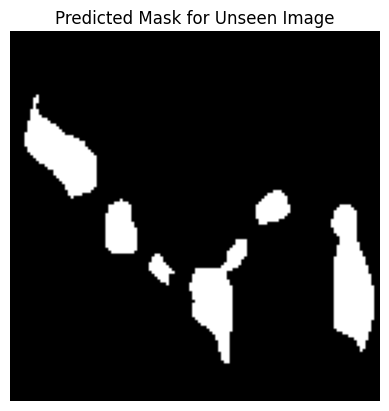

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Function to predict mask for an unseen image
def predict_mask(image_path, model, device):
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Predict the mask
    model.eval()
    with torch.no_grad():
        pred_mask = torch.sigmoid(model(img_tensor))
        # pred_mask = (pred_mask > 0.2).float()   # this method is very poor we need to change the threshold everytime threshld of c=0.5 or 0.4 is not working for all imagees...it depends image wise
        pred_mask = pred_mask.squeeze(0).cpu().numpy()
        threshold = np.percentile(pred_mask, 90)  # Get the 90th percentile threshold
        pred_mask = (pred_mask > threshold).astype(np.float32)







    pred_mask = pred_mask.squeeze(0)

    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask for Unseen Image")
    plt.axis('off')
    plt.show()


predict_mask('/content/small/small/data/manual_test/Code03630.png', model, device)


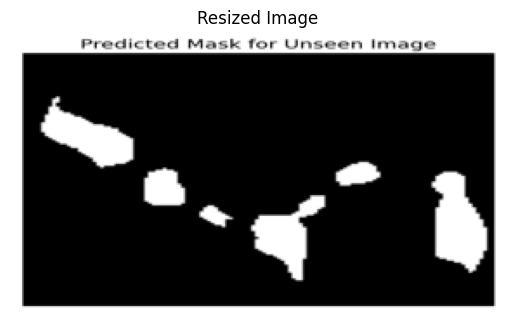

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open and resize the image
img = Image.open("/content/download.png")
img = img.resize((286, 162))

# Display the image
plt.imshow(img)
plt.title("Resized Image")
plt.axis('off')
plt.show()
